In [ ]:
!ls

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from fastai.callbacks import *

In [3]:
path = Path('../../data/large')

In [4]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0][:100].astype(float)
bestKnow_sum_constraints = pd.read_csv(path/'Best_Know1SumCV.csv', header=None).values[0][:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

In [5]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [6]:
class VAELoss(nn.Module):
    def __init__(self, hooks):
        super().__init__()
        self.hooks,self.loss_func = hooks,nn.MSELoss()
        
    def forward(self, input, target):
        base_loss = self.loss_func(input,target)
        mu,logvar = self.hooks.stored
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return base_loss + kl_loss
    
class VAEModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.mu     = nn.Linear(nf*w,d)
        self.logvar = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def sample(self, fts):
        mu = self.mu(fts)
        std = torch.exp(0.5 * self.logvar(fts))
        sample = mu + torch.randn_like(std)*std
        return sample

    def forward(self, x):
        fts = self.act(torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1))
        return self.sample(fts)

model = VAEModel()
hooks = hook_outputs([model.mu,model.logvar], detach=False)
loss_func = VAELoss(hooks)

In [9]:
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainerNoNoise, model=model, loss_func=loss_func, window=nn_window)
speed_metric = partial(SpeedMetric, threadhold=0.1)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[nn_trainer],
                   metrics=[speed_metric],
                   optimal_fitness_values=bestKnow, optimal_sum_constraints=bestKnow_sum_constraints)
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 00:39
SpeedMetric(success rate): 0.1900


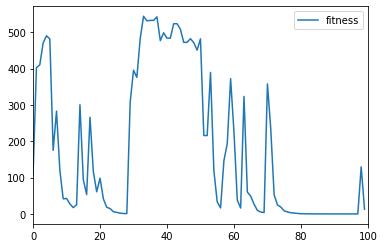

In [10]:
opt.run(total_generations)

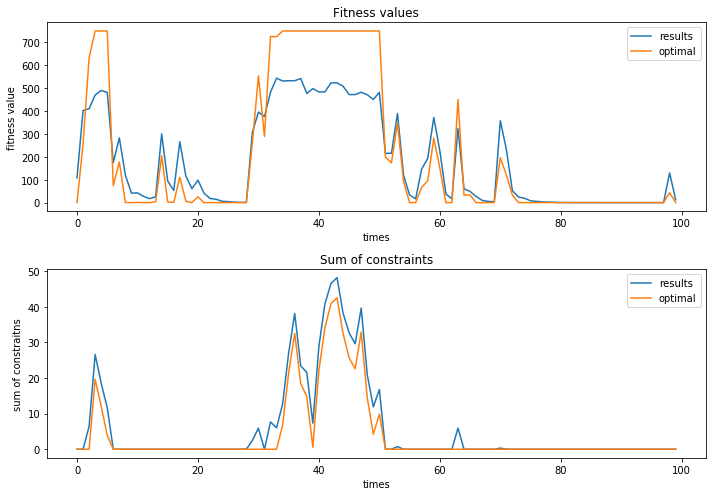

In [11]:
opt.recorder.plot();

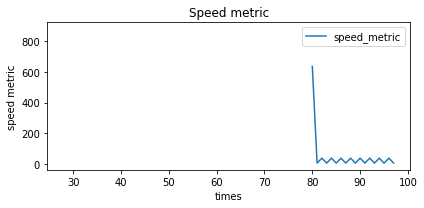

In [12]:
opt.recorder.plot_metrics();

In [26]:
pred = opt.nn_trainer_no_noise.get_next_best()
pred

tensor([-0.8879, -0.4517, -0.3752, -0.1673, -1.0296, -0.8313,  0.0205,  0.3678,
         1.0005,  1.2241, -0.5305, -0.5888,  0.3843, -1.1301, -1.0447, -0.1907,
         0.0694,  0.1155,  0.1190, -0.7606, -0.7171, -0.5586, -0.4981, -0.1404,
        -0.4762, -0.1477, -0.0385, -0.4269, -0.9569,  0.7873])

In [27]:
fitness_func(opt.best, 0, 0), fitness_func(pred, 0, 0)

(12.894028, tensor(12.4009))

In [28]:
constraint_func(opt.best, ab, opt.time-1), constraint_func(pred, ab, opt.time-1)

(-18.486369387531653, tensor(-18.6791))

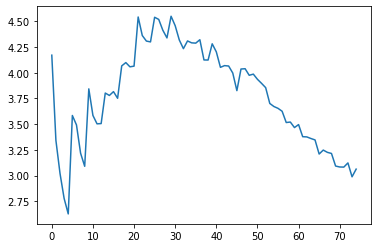

In [30]:
plt.plot(opt.nn_trainer_no_noise.train_losses)